## Task - 1: Understanding Sentiment Aalysis and RNNS

**Q1. What is sentiment analysis and it's applications?**

Sentiment analysis is the process of enabling a computer to determine the emotional tone—negative, neutral, or positive of a user's message based on digital text.

Applications of sentiment analysis:
- **Social Media Monitering:**
    - Tracks public opinion on brands, products or events.
    - Identify viral trends or customer sentiment shifts in real life.

- **Customer Feedeback Analysis:**
    - Analyze reviews to help understand satisfaction levels.
    - Prioritize complaints or negative experiences for faster resolution.

**Q2. How RNNs differ from traditional feedforward neural networks?**

A Recurrent Neural Network (RNN) is specially designed to handle sequential data or time series data, where the output at a particular time depends on previous inputs.

They remember previous inputs using internal memory, which helps in learning patterns over time. For example, traditional neural networks can recognize digits in images, while RNNs are used for tasks like predicting the next word in a sentence, speech recognition, or stock price forecasting, where the order and context of data matter.

**Q3. The concept of hidden states and how information is passed through time steps in RNNs.**

***Concept of Hidden States in RNNs***

In RNNs, a hidden state is a memory-like vector that stores information from previous time steps. It's the key component that allows RNNs to handle sequential data like sentences, time series, or speech.

***How Information is Passed Through Time Steps***
1. At **Time Step t = 1**:
    - Inputs: $x_1$
    - Hidden state: $h_0$ (usually initialized as zeros)
    - RNN Computes

    $$
    h_1 = \tanh(W_{xh} \cdot x_1 + W_{hh} \cdot h_0 + b)
    $$

    - $h_1$ now stores the information from $x_1$

2. At **Time Step t = 2**:
    - Input: $x_2$
    - Previous hidden state: $h_1$
    - RNN computes:

    $$
    h_2 = \tanh(W_{xh} \cdot x_2 + W_{hh} \cdot h_1 + b)
    $$

    - Now $h_2$ contains both $x_2$ and prior context $h_1$

3. This continous for all time steps:

$$
h_t = \tanh(W_{xh} \cdot x_t + W_{hh} \cdot h_{t-1} + b)
$$

Each hidden state carries the essence of all previous inputs, making the network capable of remembering sequences.

**Q4. Common issues with RNNs such as vanishing and exploding gradients.**

RNNs often face two major issues:

- ***Vanishing gradients***: Gradients become too small during training, making it hard to learn long-term dependencies.
- ***Exploding gradients***: Gradients become too large, causing unstable training or model crash.

These problems occur during backpropagation through many time steps.

In [2]:
import random
import numpy as np
import tensorflow as tf
import os

def set_global_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
set_global_seed(42)

## Task - 2: Dataset Preparation

#### Loading the IMDB dataset from the TensorFlow

In [4]:
# Importing suitable packages
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# Loading the dataset, the tokenization is already done by the TensorFlow
vocab_size = 10_000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = vocab_size)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Shape of the training and test datasets
print(f"Shape of the X_train dataset: {x_train.shape} and Y_train: {y_train.shape}")
print(f"Shape of the X_test dataset: {x_test.shape} and Y_test: {y_test.shape}")

Shape of the X_train dataset: (25000,) and Y_train: (25000,)
Shape of the X_test dataset: (25000,) and Y_test: (25000,)


In [7]:
# First few examples from the train dataset
for i in range(5):
    print(f"{x_train[i]}: {y_train[i]}")

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]: 1
[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012

In [8]:
# Finding the maximum review length
maxlen_review = max(len(review) for review in x_train)
print(f"Maximum review length in training data: {maxlen_review}")

Maximum review length in training data: 2494


> **Note**: Using the *maximum length* can lead to large input sizes and **slower training**, especially if a few reviews are extremely long.

In [9]:
# Setting maxlen to the 90th percentile of review lengths to capture most data while avoiding very long outliers
review_lengths = [len(review) for review in x_train]
maxlen = int(np.percentile(review_lengths, 90))

print(f"Using maxlen = {maxlen} for padding.")

Using maxlen = 467 for padding.


In [10]:
# Applying the padding on the training and testing data
x_train_padded = pad_sequences(x_train, maxlen = maxlen, padding = "post", truncating = "post")
x_test_padded = pad_sequences(x_test, maxlen = maxlen, padding = "post", truncating = "post")

In [11]:
print(f"Shape of padded x_train: {x_train_padded.shape}")
print(f"Shape of padded x_test: {x_test_padded.shape}")

Shape of padded x_train: (25000, 467)
Shape of padded x_test: (25000, 467)


## Task - 3: Building RNN Model

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, Embedding, LSTM, Dense

First, creating an RNN model with just just a single LSTM layer and a single dense layer.
- vocab_size = 10_000 (similar to what we used while downloading the dataset)
- input_length = maxlen (90th percentile of review lengths)
- embedding_size = 128
- lstm_units = 64
- dense_units = 32

In [13]:
class RNNmodel(Model):
    def __init__(self, vocab_size, input_length, embedding_size: int = 128, lstm_units: int = 64, dense_units: int = 32):
        super(RNNmodel, self).__init__()

        # Embedding Layer
        self.embedding_layer = Embedding(input_dim = vocab_size, output_dim = embedding_size, input_length = input_length)

        # LSTM layers
        self.lstm_layer = LSTM(units = lstm_units)

        # Dense Layers
        self.dense_layer = Dense(units = dense_units*2, activation = "relu")

        # Output Layer
        self.output_layer = Dense(units = 1, activation = "sigmoid")

    def call(self, inputs):
        x = self.embedding_layer(inputs)
        x = self.lstm_layer(x)
        x = self.dense_layer(x)
        return self.output_layer(x)

Now for the model compiling:
- loss funtion is set to "binary_crossentropy" as there are only 2 classification labels.
- Adam optimizer is used
- For metrics accuracy is taken. (ratio of Total number of correct prediction with total predictions)

In [14]:
model = RNNmodel(vocab_size = vocab_size, input_length = maxlen)

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Task - 4: Train the Model

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [16]:
# Splitting the data into Training and validation dataset with 80% in training and 20% in test
x_train_final, x_val, y_train_final, y_val = train_test_split(x_train_padded, y_train, test_size = 0.2, random_state = 42)

In [17]:
# Creating a early_stop function that wll stop the model training when the `val_loss` won't decrease for 3 epochs
early_stop = EarlyStopping(
    monitor = "val_loss",
    patience = 3,
    restore_best_weights = True
)

Training the model on 10 epochs and 64 batch_size.

In [18]:
history = model.fit(x_train_final, y_train_final,
                    epochs = 10,
                    batch_size = 64,
                    validation_data = (x_val, y_val),
                    callbacks = [early_stop])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.5025 - loss: 0.6929 - val_accuracy: 0.4972 - val_loss: 0.6927
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5292 - loss: 0.6827 - val_accuracy: 0.5004 - val_loss: 0.6974
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.5386 - loss: 0.6546 - val_accuracy: 0.4986 - val_loss: 0.7315
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5534 - loss: 0.6324 - val_accuracy: 0.4972 - val_loss: 0.7853


It can be seen clearly that even if the accuracy for both the training and validation dataset is increasing the loss value for the validation data is keep on increasing. That's why the callback function is stopping the model training.

## Taske - 5: Model Evaluation

Model's perforance on the test dataset.

In [19]:
loss, accuracy = model.evaluate(x_val, y_val)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4973 - loss: 0.6923
Test Loss: 0.6927
Test Accuracy: 0.4972


Plotting the accuracy and loss of the training and validation dataset on the graph.

In [20]:
import matplotlib.pyplot as plt

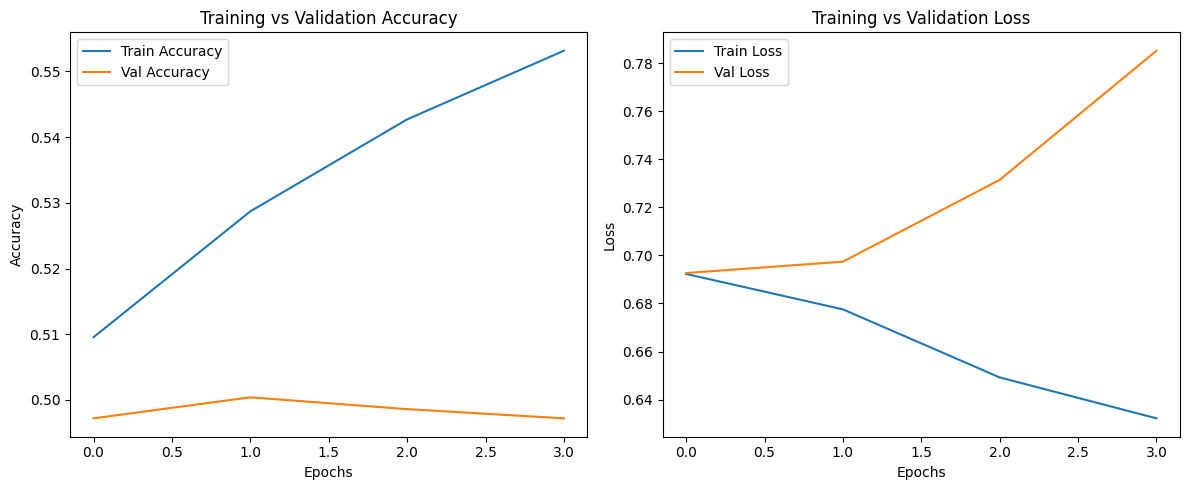

In [21]:
# Plot training & validation accuracy
plt.figure(figsize = (12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label = "Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"], label = "Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

1. Accuracy Plot Analysis
- ***Training Accuracy:*** Shows a steady increase across epochs means model is learning the training data.

- ***Validation Accuracy***: Peaks early and then declines which suggests the model is overfitting after a couple of epochs.

2. Loss Plot Analysis
- ***Training Loss***: Decreases consistently suggests that the model is minimizing error on training data.

- ***Validation Loss***: Increases steadily which gives another strong sign of overfitting.

**Conclusion**
- The RNN model is overfitting: it performs well on training data but fails to generalize.

- The widening gap between training and validation curves confirms this.



## Task - 6: Hyper parameter tuning

For tuning the hyper parameters for the model, I will be using the `keras_tuner` library.

In [22]:
import keras_tuner as kt
from tensorflow.keras import layers, Model, optimizers

Defines an LSTM-based model for binary text classification. Key hyperparameters like embedding size, LSTM units, dense units, and learning rate are tunable using Keras Tuner. The model uses an Embedding layer followed by LSTM and Dense layers with sigmoid output.

In [23]:
def model_builder(hp):
  vocab_size = 10_000
  input_length = maxlen

  # Hyper parameters to tune
  embedding_dim = hp.Choice("embedding_dim", [64, 128, 256])
  lstm_units = hp.Int("lstm_units", min_value = 32, max_value = 128, step = 32)
  dense_units = hp.Int("dense_units", min_value = 32, max_value = 256, step = 32)
  learning_rate = hp.Choice("learning_rate", [1e-3, 1e-4, 2e-4, 5e-4])

  inputs = layers.Input(shape = (input_length, ))
  x = layers.Embedding(input_dim = vocab_size, output_dim = embedding_dim)(inputs)
  x = layers.LSTM(units = lstm_units)(x)
  x = layers.Dense(units = dense_units, activation = "relu")(x)
  outputs = layers.Dense(units = 1, activation = "sigmoid")(x)

  model = Model(inputs, outputs)

  model.compile(optimizer = optimizers.Adam(learning_rate = learning_rate),
                loss = "binary_crossentropy",
                metrics = ["accuracy"])

  return model

Initializes Keras Tuner with `RandomSearch` to optimize validation accuracy.  Performs 10 trials with 1 execution each and saves results in the `'kt_dir/imdb_rnn_tuning'` directory.

In [24]:
tuner = kt.RandomSearch(
    model_builder,
    objective = "val_accuracy",
    max_trials = 10,
    executions_per_trial = 1,
    directory = "kt_dir",
    project_name = "imdb_rnn_tuning"
)

In [25]:
tuner.search(x_train_final, y_train_final,
             epochs = 10,
             batch_size = 64,
             validation_data = (x_val, y_val))

Trial 10 Complete [00h 01m 32s]
val_accuracy: 0.5284000039100647

Best val_accuracy So Far: 0.8447999954223633
Total elapsed time: 00h 15m 39s


Retrieving the best hyper-parameters found using the `Keras_tuner`.

In [26]:
best_model = tuner.get_best_models(num_models = 1)[0]
best_hyperparams = tuner.get_best_hyperparameters()[0]

print("Best hyperparameters:")
print(best_hyperparams.values)

Best hyperparameters:
{'embedding_dim': 256, 'lstm_units': 128, 'dense_units': 192, 'learning_rate': 0.001}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Re-training the models with the best hyper-parameters to make visualizations.

In [31]:
best_rnn_model = RNNmodel(
    vocab_size = vocab_size,
    input_length = maxlen,
    embedding_size = best_hyperparams.get("embedding_dim"),
    lstm_units = best_hyperparams.get("lstm_units"),
    dense_units = best_hyperparams.get("dense_units")
)

best_rnn_model.compile(
    loss = "binary_crossentropy",
    optimizer = optimizers.Adam(learning_rate = best_hyperparams.get("learning_rate")),
    metrics = ["accuracy"]
)

In [32]:
# Creating a early_stop function that wll stop the model training when the `val_loss` won't decrease for 3 epochs
early_stop = EarlyStopping(
    monitor = "val_accuracy",
    patience = 2,
    restore_best_weights = True
)

In [33]:
history = best_rnn_model.fit(
    x_train_final, y_train_final,
    epochs = 10,
    batch_size = 64,
    validation_data = (x_val, y_val)
)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.5053 - loss: 0.6935 - val_accuracy: 0.5144 - val_loss: 0.6955
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5070 - loss: 0.6862 - val_accuracy: 0.4994 - val_loss: 0.7101
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5360 - loss: 0.6616 - val_accuracy: 0.4948 - val_loss: 0.7613
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.5525 - loss: 0.6417 - val_accuracy: 0.4968 - val_loss: 0.8014
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.5474 - loss: 0.6290 - val_accuracy: 0.4968 - val_loss: 0.8085
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.5592 - loss: 0.6284 - val_accuracy: 0.4940 - val_loss: 0.8400
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.5587 - loss: 0.6204 - val_accuracy: 0.4970 - val_loss: 0.8577
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.5689 - loss: 0.6153 - 

In [37]:
loss, accuracy = best_rnn_model.evaluate(x_val, y_val)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8695 - loss: 0.4144
Validation Loss: 0.4346
Validation Accuracy: 0.8642


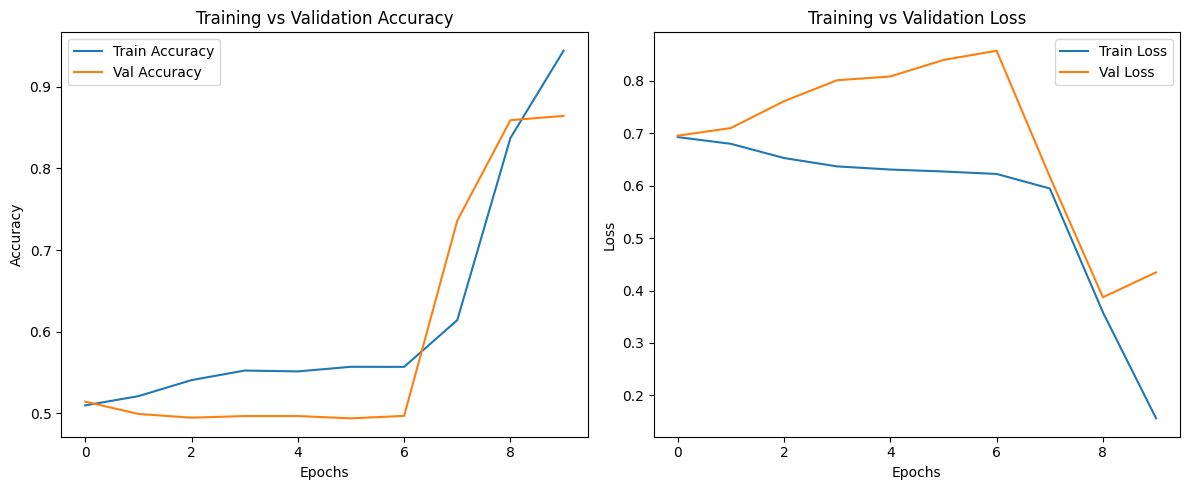

In [36]:
# Plot training & validation accuracy
plt.figure(figsize = (12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label = "Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"], label = "Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

1. Accuracy Plot Analysis
- ***Training Accuracy:*** Steadily increases and crosses 95% by epoch 9

- ***Validation Accuracy:*** Low at first, then rapidly improves after epoch 6 — reaches ~87% Indicates that the model generalized well after tuning.

2. Loss Plot Analysis
- ***Training Loss:*** Decreases consistently — model is learning effectively

- ***Validation Loss:*** Rises until epoch 6 (overfitting danger zone), then drops sharply — strong sign that early stopping kicked in at the right time

### Model Evaluation on the Test dataset.

In [35]:
loss, accuracy = best_rnn_model.evaluate(x_test_padded, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8598 - loss: 0.4437
Test Loss: 0.4445
Test Accuracy: 0.8594


## Task - 7: Comparative Analysis

In [38]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout

Creating a new Artificial Neural Network(ANN).

In [40]:
def create_ann_model(vocab_size = 10_000, input_length = maxlen):

    model = Sequential([
        Input(shape = (input_length,)),
        Embedding(input_dim = vocab_size, output_dim = 128),
        GlobalAveragePooling1D(),
        Dense(64, activation = "relu"),
        Dropout(0.3),
        Dense(1, activation = "sigmoid")
    ])

    model.compile(
        loss = "binary_crossentropy",
        optimizer = optimizers.Adam(learning_rate = 0.001),
        metrics = ["accuracy"]
    )
    return model

In [41]:
# Initialize the ANN model
ann_model = create_ann_model()

# training the FFNN model
history_ffnn = ann_model.fit(
    x_train_final, y_train_final,
    epochs = 10,
    batch_size = 64,
    validation_data = (x_val, y_val)
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5624 - loss: 0.6778 - val_accuracy: 0.7892 - val_loss: 0.4814
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7762 - loss: 0.4630 - val_accuracy: 0.8184 - val_loss: 0.3857
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8292 - loss: 0.3792 - val_accuracy: 0.8352 - val_loss: 0.3672
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8536 - loss: 0.3390 - val_accuracy: 0.8536 - val_loss: 0.3357
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8687 - loss: 0.3133 - val_accuracy: 0.8724 - val_loss: 0.2971
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8767 - loss: 0.2931 - val_accuracy: 0.8854 - val_loss: 0.2829
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8862 - loss: 0.2793 - val_accuracy: 0.8854 - val_loss: 0.2834
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9077 - loss: 0.2326 - val_accuracy: 0

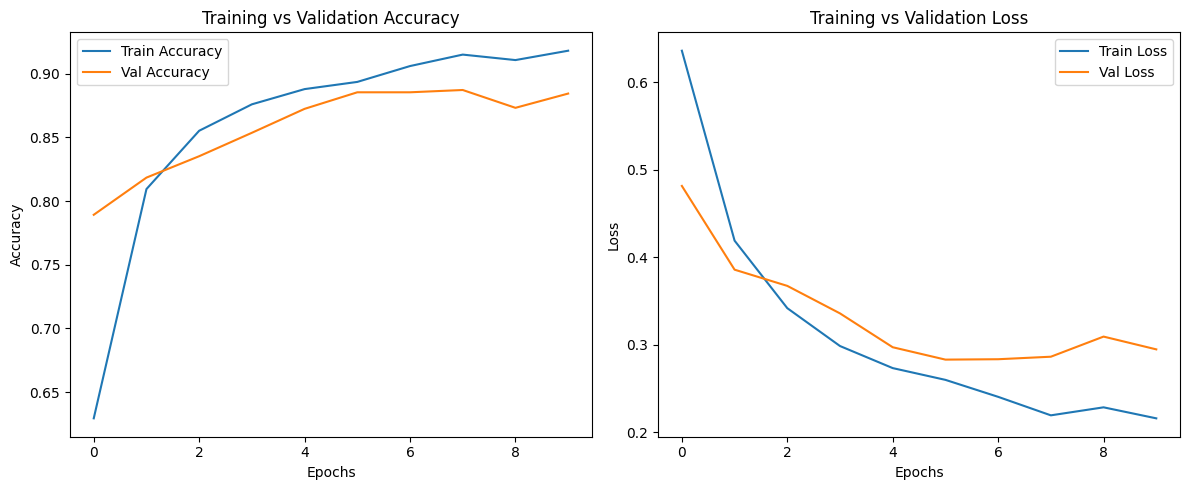

In [43]:
# Plot training & validation accuracy
plt.figure(figsize = (12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_ffnn.history["accuracy"], label = "Train Accuracy")
plt.plot(history_ffnn.history["val_accuracy"], label = "Val Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_ffnn.history["loss"], label = "Train Loss")
plt.plot(history_ffnn.history["val_loss"], label = "Val Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
ann_model.evaluate(x_test_padded, y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8834 - loss: 0.3040


[0.30250969529151917, 0.8832799792289734]

### Conclusion

- ANN outperformed RNN in both accuracy and generalization — which is surprising but valid.

- The IMDB dataset is relatively small (~25,000 samples) and binary-labeled, which means:
  - Complex sequence dependencies may not be necessary
  -A simple bag-of-words style representation (which ANN uses via GlobalAveragePooling) works well

- RNNs are powerful, but also sensitive to:

  - Overfitting on smaller datasets

  - Poor hyperparameter choices

  - Sequence length and padding



On this dataset, the simplicity and regularization of the ANN allowed it to outperform the more complex RNN. For real-world NLP tasks with larger datasets or nuanced context (like question answering, translation), RNNs (or Transformers) would still be superior.